# Evaluate Speckle Tracking Results With and Without Smoothing
---

While there is substantial overlap in the NISAR offsets, suggesting the noise is not independent from sample to sample, there is significant benefit to smoothing the results as shown here.

In [8]:
%load_ext autoreload
%autoreload 2
import nisarhdf 
from osgeo import gdal
import os
import glob
import numpy as np
import rioxarray
from nisarhdf import writeMultiBandVrt
import h5py
from datetime import datetime
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
offsetsGeom = rioxarray.open_rasterio('../../49672_5280/workingDir/offsets.geom.vrt', band_as_variable=True, mask_and_scale=True)
offsetsGeom = offsetsGeom.rename({'band_1': 'RangeOffsets', 'band_2': 'AzimuthOffsets'})

## Read JPL Processed Version that has been Subsequently Culled to Remove Outliers and Smoothed with a 3x3 Moving Average

In [11]:
keys = ['64x32', '96x64', '196x128']
bandNames = ['RangeOffsets', 'AzimuthOffsets', 'RangeSigma', 'AzimuthSigma', 'Correlation']
bandNamesCulled = ['RangeOffsets', 'AzimuthOffsets', 'RangeSigma', 'AzimuthSigma', 'Correlation']
files = [f for f in sorted(glob.glob('../../49672_5280/workingDir/offsets.layer?.vrt'))]
nisarFiles = dict(zip(keys, files))
nisarOffsetsSmooth = {}
for key in keys:
    print(nisarFiles[key].replace('.vrt', '.cull.vrt'))
    nisarOffsetsSmooth[key] = \
        rioxarray.open_rasterio(nisarFiles[key].replace('.vrt', '.cull.vrt'), band_as_variable=True, mask_and_scale=True)
    nisarOffsetsSmooth[key] = nisarOffsetsSmooth[key].rename(dict(zip([x for x in nisarOffsetsSmooth[key].data_vars], bandNamesCulled)))
    for band in bandNames:
        if band in offsetsGeom.data_vars:
            getattr(nisarOffsetsSmooth[key], band).data[:] += offsetsGeom[band][:]

../../49672_5280/workingDir/offsets.layer1.cull.vrt
../../49672_5280/workingDir/offsets.layer2.cull.vrt
../../49672_5280/workingDir/offsets.layer3.cull.vrt


## Read JPL Processed Version that has been Subsequently Culled to Remove Outliers and No Smoothing

In [12]:
files = [f for f in sorted(glob.glob('../../49672_5280-nosmooth/workingDir/offsets.layer?.vrt'))]
nisarFiles = dict(zip(keys, files))
nisarOffsets = {}
for key in keys:
    print(nisarFiles[key].replace('.vrt', '.cull.vrt'))
    nisarOffsets[key] = \
        rioxarray.open_rasterio(nisarFiles[key].replace('.vrt', '.cull.vrt'), band_as_variable=True, mask_and_scale=True)
    nisarOffsets[key] = nisarOffsets[key].rename(dict(zip([x for x in nisarOffsets[key].data_vars], bandNamesCulled)))
    for band in bandNames:
        if band in offsetsGeom.data_vars:
            getattr(nisarOffsets[key], band).data[:] += offsetsGeom[band][:]

../../49672_5280-nosmooth/workingDir/offsets.layer1.cull.vrt
../../49672_5280-nosmooth/workingDir/offsets.layer2.cull.vrt
../../49672_5280-nosmooth/workingDir/offsets.layer3.cull.vrt


## Offsets Comparision for a Column

A plot of the offsets shows clear improvement with smoothing but its difficult to visualize.

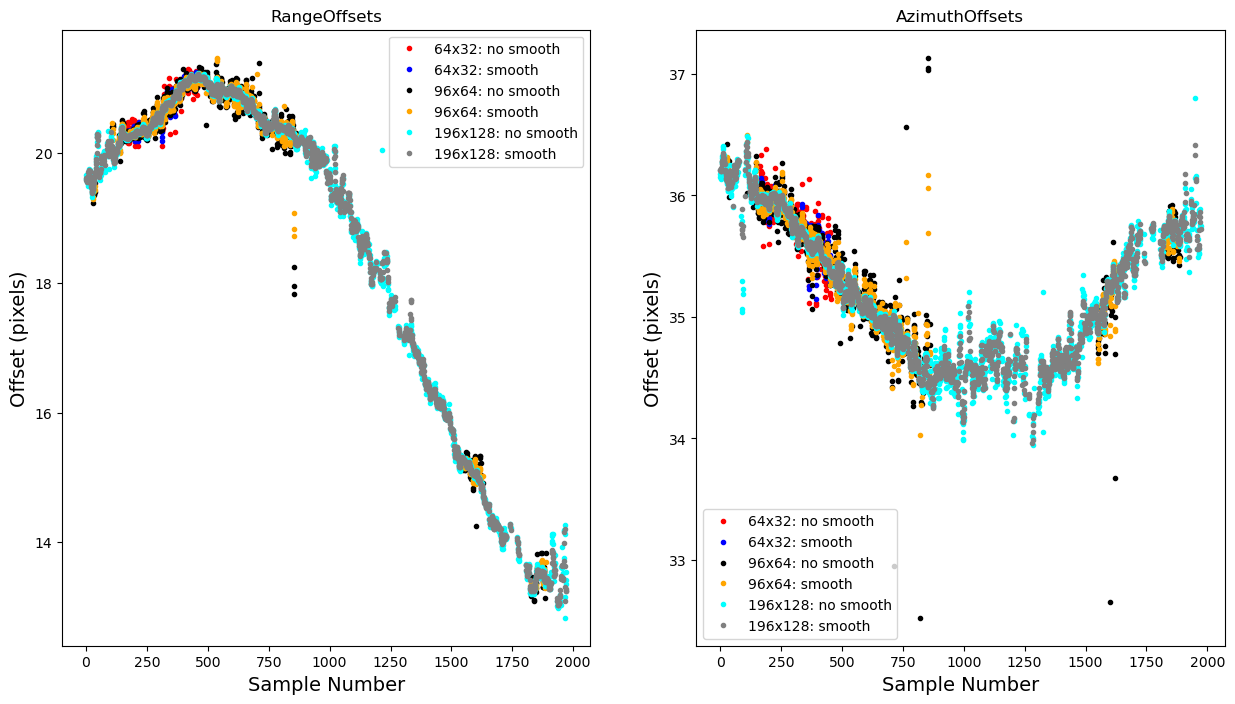

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(15, 8))
res = {'RangeOffsets': 3.35, 'AzimuthOffsets': 7}
col = 730
colors =['r', 'b', 'k', 'orange', 'cyan', 'gray']

for band, ax in zip(['RangeOffsets', 'AzimuthOffsets'], axes.flatten()):
    cI = 0 
    for key in keys:
        dataSmooth = np.array(getattr(nisarOffsetsSmooth[key], band)[:, col])
        data = np.array(getattr(nisarOffsets[key], band)[:, col])
        sigma = np.nanstd(data-dataSmooth)
        sigmaV = sigma * res[band] * 365/12.
        ax.plot(data,  '.',label=f'{key}: no smooth', color=colors[cI])
        cI += 1
        ax.plot(dataSmooth, '.', label=f'{key}: smooth ', color=colors[cI])
        cI += 1
for ax, key in zip(axes.flatten(), res.keys()):
    ax.legend()
    ax.set_title(key)
    ax.set_ylabel('Offset (pixels)', fontsize=14)
    ax.set_xlabel('Sample Number', fontsize=14)

## Comparison of Detrended Offsets

Plots linearly detrended for a portion of the profiles that are approximately linear.  Results are plotted as relative velocties (pixel offsets * resolution * 365/12).

64x32 RangeOffsets
64x32 AzimuthOffsets
96x64 RangeOffsets
96x64 AzimuthOffsets
196x128 RangeOffsets
196x128 AzimuthOffsets


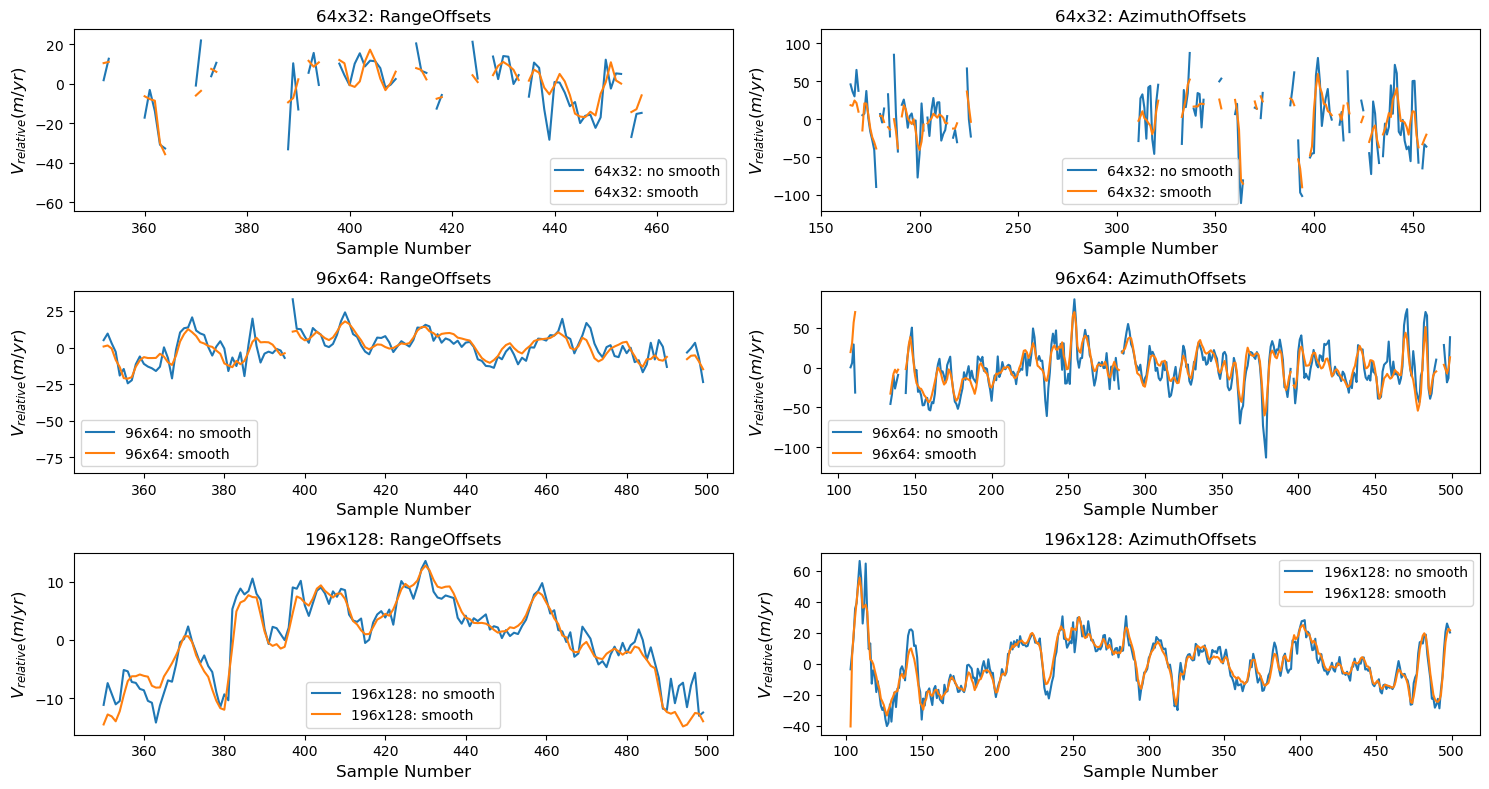

In [14]:
fig, axes = plt.subplots(3, 2, figsize=(15, 8))
res = {'RangeOffsets': 3.35, 'AzimuthOffsets': 7}
range = {'RangeOffsets': [350, 500], 'AzimuthOffsets': [100, 500]}
col = 730

for key, axesR in zip(keys,axes):
    for band, ax in zip(['RangeOffsets', 'AzimuthOffsets'], axesR):
        i1, i2 = range[band]
        x = np.arange(i1, i2)
        dataSmooth = np.array(getattr(nisarOffsetsSmooth[key], band)[:, col])[i1:i2]
        i = np.isfinite(dataSmooth)
        #print(dataSmooth[i], x[i])
        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x[i], dataSmooth[i])
        trend = x*slope + intercept
        data = np.array(getattr(nisarOffsets[key], band)[:, col])[i1:i2]
        sigma = np.nanstd(data-dataSmooth)
        sigmaV = sigma * res[band] * 365/12.
        ax.plot(x, (data - trend)*res[band]*365/12, label=f'{key}: no smooth')
        ax.plot(x, (dataSmooth-trend)* res[band] *365/12, label=f'{key}: smooth ')
        ax.set_title(f'{key}: {band}')
        print(key, band,)
        #break
        #print(dataSmooth)
        #print(data)
        #break
for ax in  axes.flatten():
    ax.legend()
    ax.set_ylabel('$V_{relative} (m/yr)$', fontsize=12)
    ax.set_xlabel('Sample Number', fontsize=12)
fig.tight_layout()

## Plot Difference of Smoothed and UnSmoothed

A the direct difference of the offsets gives an aproximation of the improved performance. 

64x32 RangeOffsets
96x64 RangeOffsets
196x128 RangeOffsets
64x32 AzimuthOffsets
96x64 AzimuthOffsets
196x128 AzimuthOffsets


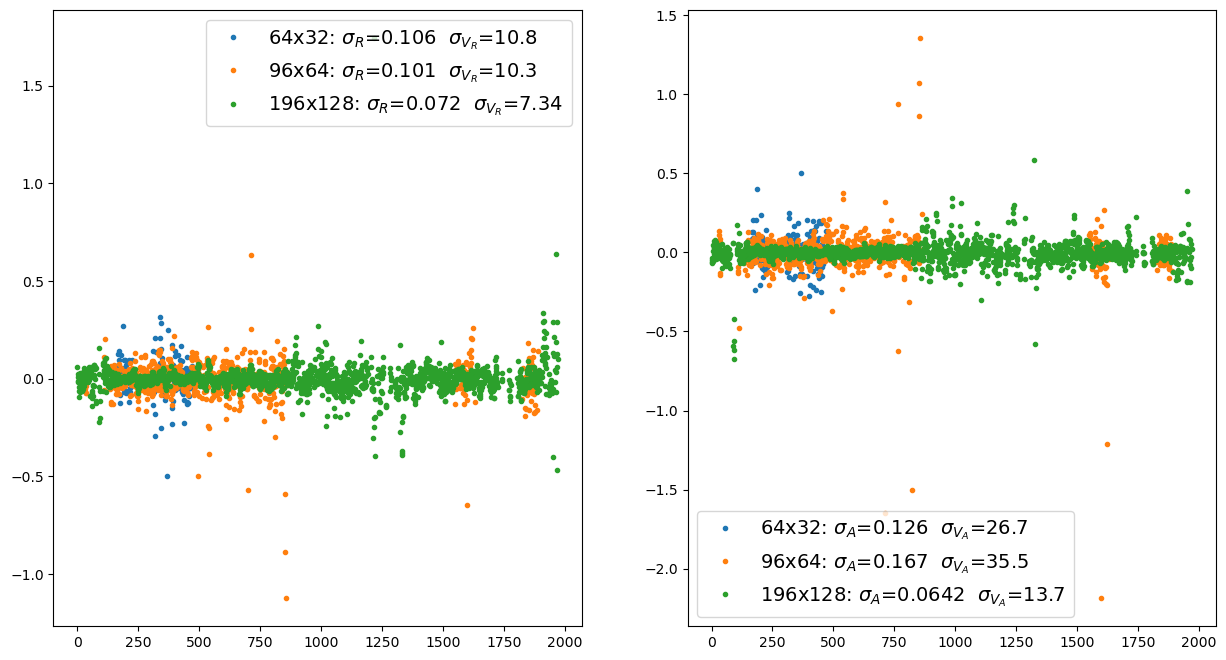

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(15, 8))
res = {'RangeOffsets': 3.35, 'AzimuthOffsets': 7}
col = 730
for band, ax in zip(['RangeOffsets', 'AzimuthOffsets'], axes.flatten()):
    for key in keys:
        dataSmooth = np.array(getattr(nisarOffsetsSmooth[key], band)[:, col])
        data = np.array(getattr(nisarOffsets[key], band)[:, col])
        sigma = np.nanstd(data-dataSmooth)
        sigmaV = sigma * res[band] * 365/12.
        ax.plot(data-dataSmooth, '.', label=f'{key}: $\sigma_{{{band[0]}}}$={sigma:.3}  $\sigma_{{V_{{{band[0]}}}}}$={sigmaV:.3} ')
        print(key, band,)
        #print(dataSmooth)
        #print(data)
        #break
for ax in axes.flatten():
    ax.legend(fontsize=14)

# Summary

**Smoothing in this example provides significant peformance improvent ranging from a few to a few 10s of m/yr. The improvement will vary depending on the overall quality of the data, but for any case smoothing should provide significant improvement even when computed from overlapping patches.**